# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle



df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [3]:
user_article_interactions = df.groupby('email')['article_id'].count().describe()
user_article_interactions

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

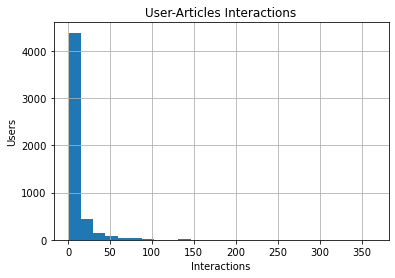

In [4]:
df['email'].value_counts().hist(bins = 25)
plt.title('User-Articles Interactions')
plt.xlabel('Interactions')
plt.ylabel('Users')
plt.show()

50% of individuals interact with 3 articles or fewer. The maximum number of user-article interactions by one user is 364.

`2.` Remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles by id
# Full duplicates
df_content.duplicated().sum()

0

In [6]:
# Dublicated content:
df_content.duplicated(['doc_body', 'doc_description', 'doc_full_name']).sum()

0

In [7]:
# Duplicates by id ()
df_content.duplicated('article_id').sum()

5

In [8]:
# Duplicated articles:
df_content[df_content.duplicated(['article_id']) == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id', keep='first')

In [10]:
# Check - result should be 0, not 5
df_content.duplicated('article_id').sum()

0

In [11]:
# The number of unique articles that have at least one interaction:
unique_articles = df.article_id.nunique()
unique_articles

714

In [12]:
# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()  
total_articles

1051

In [13]:
# The number of unique users:
unique_users = df['email'].nunique()   
unique_users

5148

In [14]:
# The number of user-article interactions:
user_article_interactions = len(df)  
user_article_interactions

45993

`4.` Find the most viewed **article_id**, as well as how often it was viewed.  We know that after talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
# The most viewed article in the dataset as a string with one value following the decimal: 
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values(ascending=False).index.values[0])
most_viewed_article_id

'1429.0'

In [16]:
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id')['email'].count().max()
max_views

937

In [17]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below returns the **n** top articles ordered with most interactions as the top. 

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    id_top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index.values[:n]
    top_articles = df[df['article_id'].isin(id_top_articles)]['title']
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    id_top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index.values[:n]
    id_top_articles = list(map(lambda a: str(a), id_top_articles)) 
    return id_top_articles# Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

1             healthcare python streaming application demo
2               use deep learning for image classification
6               use deep learning for image classification
8             healthcare python streaming application demo
13            healthcare python streaming application demo
                               ...                        
45942    use xgboost, scikit-learn & ibm watson machine...
45943          insights from new york car accident reports
45957          insights from new york car accident reports
45958                       visualize car data with brunel
45960          insights from new york car accident reports
Name: title, Length: 6551, dtype: object
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The **df** dataframe is shaped with users as the rows and articles as the columns in such way: 

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  All entries where a user has interacted with an article is 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, I compute similarity as the dot product of two users. 

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Similarity of each user to the provided user
    similarity_each_user = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    similarity_each_user = similarity_each_user.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = similarity_each_user.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [22]:
# Example:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` The functions below returns the articles I would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for article in article_ids:
        name = df[df['article_id'] == float(article)]['title'].iloc[0]
    
        article_names.append(name)
       
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # return the ids and names
    article_ids = user_item.loc[user_id]
    article_ids =  [str(aid) for aid in article_ids[article_ids == 1].index]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    user_ids = find_similar_users(user_id)
    recs = df[df['user_id'].isin(user_ids)]['article_id']
    recs = list(set(recs))
    
    return recs[:m] # return your recommendations for this user_id    

In [24]:
# Check results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'higher-order logistic regression for large datasets',
 'the greatest public datasets for ai – startup grind']

`4.` Improving the consistency of the **user_user_recs** function from above:

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking is obtained from the **top_articles** function.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Dataset for user-item interaction:
    user_item_interaction = df.groupby(['user_id'])['article_id'].count()
    # Number of users:
    number_of_users = user_item.shape[0]
    #
    # Neighbor_id column
    id_of_neighbor = [u_id for u_id in range(1, number_of_users) if u_id != user_id]
    
    
    number_of_interactions = []
    similarity = []
    for u_id in id_of_neighbor:
        number_of_interactions.append(user_item_interaction.loc[u_id])
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[u_id]))
        
    # Dataframe for neigbours:
    neighbors_df = pd.DataFrame({'neighbor_id': id_of_neighbor, 
                                 'similarity': similarity,
                                 'num_interactions': number_of_interactions})
    
    # Sort the dataframe:
    neighbors_df.sort_values('similarity', ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    
    # Get top_m neighbor_id
    top_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # set article_ids seen by top-m neighbors
    recs = []
    for u_id in top_neighbors:
        article_ids = user_item.loc[u_id]
        recs.extend([str(aid) for aid in article_ids[article_ids == 1].index])

    # remove duplicate
    recs = list(set(recs[:m]))

    # set article names and remove duplicate
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))
        
    return recs, rec_names

In [26]:
# Example:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)

The top 10 recommendations for user 20 are the following article ids:
['53.0', '727.0', '793.0', '1271.0', '89.0', '1053.0', '1186.0', '981.0', '495.0', '232.0']


In [27]:
# The user that is most similar to user 1:
find_similar_users(1)[0]

3933

In [28]:
# The user that is the 10th most similar to user 131:
find_similar_users(131)[9]

3910

If we were given a new user, we do not have a new user in our database, therefore, the best way will be to apply get_top_articles() function and recommend most popular articles:


In [29]:
new_user = '0.0'

# Provide a list of the top 10 article ids for a new_user using rank based method
new_user_recs = get_top_article_ids(10)
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Here, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [30]:
# Load the matrix from the pickle file:
user_item_matrix = pd.read_pickle('data/user_item_matrix.p')

In [31]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` We can use SVD method here because the User-Item matrix does not have any missing values.

In [32]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

`3.` As the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix:

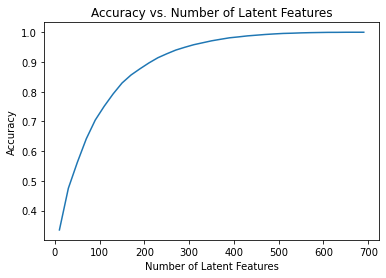

In [33]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` Therefore, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.  

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [34]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # User-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)
    
    # User-item matrix of the testing dataframe 
    user_item_test = create_user_item_matrix(df_test)
    
    # Test user ids
    test_idx = user_item_test.index
    test_idx = list(set(test_idx))
    
    # Test article ids
    test_arts = user_item_test.columns
    test_arts = list(set(test_arts))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

20

In [36]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(set(user_item_test.index) - set(user_item_train.index))

662

In [37]:
# How many movies can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [38]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
len(test_arts) - sum(user_item_train.columns.isin(test_arts))

0

`5.` Use the **user_item_train** dataset from above to find U, S, and V transpose using SVD:

In [39]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [40]:
# decomposition to predict on test data
common_idx_train = user_item_train.index.isin(test_idx)
common_col_train = user_item_train.columns.isin(test_arts)

In [41]:
u_test = u_train[common_idx_train, :]
vt_test = vt_train[:, common_col_train]

In [42]:
train_sum_errors = []
test_sum_errors = []

num_latent_feats = np.arange(10,700+10,20)
user_item_test_subset = user_item_test.loc[list(set(user_item_train.index) & set(test_idx))]


for k in num_latent_feats:

    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    user_item_train_dot = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_dot = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # computation of errors:
    differenses_train = np.subtract(user_item_train, user_item_train_dot)
    differenses_test = np.subtract(user_item_test_subset, user_item_test_dot)
    
    train_errors = np.sum(np.sum(np.abs(differenses_train)))
    train_sum_errors.append(train_errors)
    
    test_errors = np.sum(np.sum(np.abs(differenses_test)))
    test_sum_errors.append(test_errors)

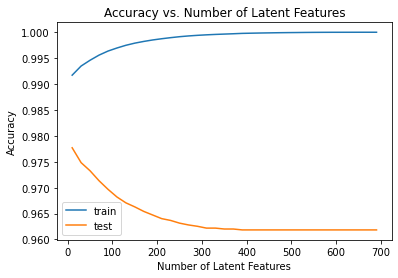

In [43]:
# Make a plot:
plt.plot(num_latent_feats, 1 - (np.array(train_sum_errors)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train');
plt.plot(num_latent_feats, 1 - (np.array(test_sum_errors)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])), label='test');
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

We can see here an overfitting of the model. Most probably, it is because we have a small dataset. Also, we do not have much common users between the training and the test datasets, therefore, we can improve our recommendation system with other recommendation methods. Another way is to implement A/B testing or take a feedback from the users if they found reccommendations useful. 